In [21]:
# mount drive
from google.colab import drive
drive.mount("/drive") 

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [22]:
# imports
import numpy as np
import pandas as pd

In [23]:
# imports for plots
from plotly import graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio

pio.templates.default = "plotly_white"

In [24]:
# load data
# weather variables to use
selected_cols = ["cumulative_GDD", "cumulative_PREC", "cumulative_WS2M", "cumulative_RH2M"]

dict_data = {}

for col in selected_cols:
  pathname = f"/drive/My Drive/Colab Notebooks/AgriEdge/data_univariate_clustering/{col}.csv"

  dict_data[col] = pd.read_csv(pathname, index_col=0)

In [25]:
# function to aggregate data
# aggregation by mean
def aggregate_data(data):
  return np.mean(data.values, axis=0)

# create data frame of aggregated data
aggregated_data = pd.DataFrame()

for col in selected_cols:
  aggregated_data[col] = aggregate_data(dict_data[col])

aggregated_data

,cumulative_GDD,cumulative_PREC,cumulative_WS2M,cumulative_RH2M
0,21.150769,1.100513,1.834103,59.658462
1,42.307436,2.399487,3.751282,118.211026
2,63.716538,3.654103,5.608462,178.530256
3,84.996282,5.778974,7.837179,241.111538
4,106.240769,7.982051,10.203333,303.233333
...,...,...,...,...
264,4579.296923,503.602051,572.560000,17160.703846
265,4606.836026,503.667692,574.913077,17205.780000
266,4634.609872,503.706154,577.336410,17251.305641
267,4662.670385,503.748718,579.601026,17296.356154


In [26]:
# train a standard scaler
from sklearn.preprocessing import StandardScaler

# build then train
standard_scaler = StandardScaler()
standard_scaler.fit(aggregated_data)

# transform data 
standarized_data = pd.DataFrame(standard_scaler.transform(aggregated_data), columns=selected_cols)

In [27]:
# check aggregation
fig = go.Figure(data=[
                      go.Scatter(y=standarized_data[col], name=col)
                      for col in selected_cols
])

fig.show()

In [28]:
# perform explanatory PCA decomposition
from sklearn.decomposition import PCA

# build and fit
pca = PCA()
pca.fit(standarized_data)

print(pca.explained_variance_ratio_)
# print(pca.components_)

[9.89318934e-01 1.04612977e-02 1.83848713e-04 3.59193691e-05]


In [29]:
# stacked bar chart view explained variance ratio
# pick up the appropriate number of component

component_names = [f"component_{i}" for i in range(1, len(selected_cols) + 1)]

fig = go.Figure(data=[
                      go.Bar(y=["Explained variance ratio"], x=[pca.explained_variance_ratio_[i]], name=component_names[i], orientation='h')
                      for i in range(len(selected_cols))
])


fig.update_layout(
    title_text="Explained variance ratio for each PC",
    height=500,
    width=1000,
    barmode="stack",
    xaxis={
    "tickformat": ',.0%',
    "range": [0,1]
  }
)

fig.show()

In [30]:
# Reduce dimension using PCA
# keep 1 component
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(standarized_data)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [31]:
# contribution of each weather variable in PC
pca.components_

array([[-0.4988385 , -0.49682952, -0.50187259, -0.50243853]])

We trained a PCA model to perform dimension reduction.
A crop year will be represented as a matrix (269 x 3)
We will perform dimension reduction on each crop year to get from (269 x 3) --> (269 x 1)

**Description of the pipeline**

1. split original data set to crop year matrices
2. standarize these crop year using the trained standarized_scaler
3. reduce dimension of each crop year using the trained pca
4. gather all these crop years in a data frame (39 x 269)

This is the data that will be used in to cluster crop years


**Clustering** 
All we need to do is to pass this data frame through the clustering pipeline


In [32]:
# load original data
original_data = pd.read_csv("/drive/My Drive/Colab Notebooks/AgriEdge/datasets/processed_weather_3.csv")

In [33]:
# pre procecss following the description above

clustering_data = pd.DataFrame()

for crop_year in original_data["crop_year"].unique():
  # selected crop year an its weather variables
  query = original_data["crop_year"] == crop_year
  data = original_data[query][selected_cols].copy()

  # standarize and reduce dimension
  data = standard_scaler.transform(data)
  data = pca.transform(data)

  # add to data frame
  clustering_data[crop_year] = data.T[0]

# transpose to get the desired data frame
# with crop years as observations

clustering_data = clustering_data.T
clustering_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268
1982,3.517127,3.494108,3.474145,3.448851,3.428882,3.408964,3.388273,3.366136,3.334631,3.285613,3.264151,3.244899,3.226973,3.211129,3.194003,3.177390,3.159480,3.142429,3.126079,3.109955,3.092170,3.070225,3.052175,3.037122,3.019794,3.003416,2.985677,2.963729,2.944151,2.926100,2.904898,2.887204,2.870352,2.852392,2.828818,2.810433,2.791394,2.774683,2.757773,2.740243,...,-2.839830,-2.862981,-2.884903,-2.907356,-2.929626,-2.951647,-2.973388,-2.995630,-3.017981,-3.040791,-3.063316,-3.084997,-3.106712,-3.126926,-3.147676,-3.171325,-3.193713,-3.216298,-3.238151,-3.259589,-3.281410,-3.305232,-3.327611,-3.349444,-3.371425,-3.394694,-3.415083,-3.433772,-3.454216,-3.476481,-3.506731,-3.534060,-3.565444,-3.589398,-3.611688,-3.633430,-3.656981,-3.680257,-3.701050,-3.722852
1983,3.518062,3.500729,3.482375,3.447764,3.423598,3.401874,3.324231,3.267786,3.235268,3.205137,3.188510,3.172707,3.158767,3.142443,3.121952,3.102001,3.076057,3.049756,3.029154,3.011961,2.994731,2.976582,2.947410,2.835760,2.765642,2.734946,2.715467,2.698548,2.681547,2.662837,2.640337,2.620412,2.604365,2.588811,2.573097,2.557214,2.541987,2.527472,2.512823,2.497117,...,-2.021984,-2.041797,-2.060650,-2.079646,-2.099743,-2.121564,-2.143293,-2.167081,-2.188327,-2.211657,-2.234635,-2.256170,-2.279172,-2.302044,-2.329871,-2.350368,-2.373518,-2.394854,-2.417877,-2.439057,-2.459345,-2.481786,-2.503415,-2.524659,-2.546823,-2.569696,-2.590743,-2.610415,-2.631219,-2.653041,-2.674268,-2.699006,-2.720699,-2.742065,-2.764131,-2.786745,-2.808564,-2.830362,-2.851240,-2.874152
1984,3.516991,3.497026,3.475757,3.457537,3.438448,3.420530,3.403129,3.386716,3.365230,3.334229,3.306806,3.287517,3.265002,3.245937,3.222761,3.195486,3.174535,3.155360,3.119122,3.088113,3.063186,3.011352,2.968652,2.943209,2.924856,2.864504,2.842155,2.825111,2.808162,2.789530,2.752039,2.685615,2.629894,2.554381,2.528403,2.510992,2.485115,2.442946,2.405346,2.384670,...,-2.358090,-2.385550,-2.409719,-2.430814,-2.454674,-2.475513,-2.495201,-2.514785,-2.533140,-2.554464,-2.573778,-2.598126,-2.621590,-2.642697,-2.662818,-2.691695,-2.718495,-2.749099,-2.773923,-2.796495,-2.818135,-2.839478,-2.861216,-2.882579,-2.904324,-2.926420,-2.946535,-2.966935,-2.986245,-3.008470,-3.032240,-3.053559,-3.073287,-3.094001,-3.116245,-3.139892,-3.162007,-3.184852,-3.208819,-3.233725
1985,3.516042,3.495539,3.476207,3.457289,3.437889,3.406618,3.389126,3.366275,3.347074,3.327043,3.306326,3.287839,3.269348,3.248675,3.223765,3.199077,3.181438,3.163517,3.141844,3.124282,3.058322,2.981809,2.945834,2.904782,2.805175,2.766479,2.733158,2.698821,2.669494,2.622678,2.573795,2.546210,2.524204,2.499186,2.469554,2.442501,2.423410,2.405852,2.389574,2.373712,...,-1.931599,-1.952956,-1.973544,-1.994948,-2.016657,-2.037608,-2.058501,-2.080053,-2.100645,-2.121480,-2.142865,-2.165558,-2.189105,-2.210655,-2.231640,-2.252471,-2.274608,-2.302662,-2.328632,-2.350966,-2.374270,-2.396908,-2.419349,-2.440385,-2.460933,-2.482483,-2.503050,-2.524693,-2.546814,-2.570515,-2.593008,-2.617912,-2.639813,-2.662107,-2.683375,-2.705386,-2.727311,-2.751593,-2.774862,-2.796507
1986,3.511996,3.492907,3.476072,3.457344,3.437362,3.419269,3.401677,3.381961,3.362386,3.341550,3.321435,3.301628,3.281057,3.264611,3.248838,3.232885,3.215130,3.197517,3.161197,3.130162,3.110667,3.089327,3.069082,3.049778,3.031119,3.013796,2.995473,2.976605,2.943366,2.925383,2.900579,2.876610,2.858058,2.817016,2.799133,2.760129,2.730692,2.702906,2.687517,2.671067,...,-2.257600,-2.280428,-2.320084,-2.349280,-2.382398,-2.418331,-2.442597,-2.462692,-2.496271,-2.533752,-2.556225,-2.576999,-2.597441,-2.620841,-2.644176,-2.667136,-2.689599,-2.712710,-2.740181,-2.764549,-2.786118,-2.807379,-2.829568,-2.853777,-2.876288,-2.897968,-2.920296,-2.943261,

In [34]:
# plot data
# impossible to interprate results
x = clustering_data.columns

fig = go.Figure()

# number of the years
for i in range(0, 39):
  fig.add_trace(
      go.Scatter(x=x, y=clustering_data.values[i], name=str(clustering_data.index[i]))
  )
  

fig.update_layout(
    title="for crop year",
    height=500,
    width=800
)

fig.show()

In [35]:
metric = "euclidean"
linkage_method = "ward"

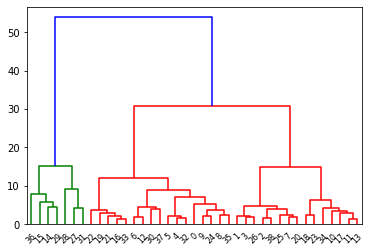

In [36]:
# dendrogram to have an idea about aggregation procedure
# and the evolution between cluster distance

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

Z = linkage(clustering_data, metric=metric, method=linkage_method)
# fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [37]:
# use Calanski-Harabasz index
# to choose the right number of cluster

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics


# where to store CH index
arr_calanski = {}

# max possible number of cluster
max_k = 10

# data
X = clustering_data

# loop over number of clusters
for k in range(2, max_k):
  # build model 
  model = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, affinity=metric)
  model = model.fit(X)

  # clusters label
  labels = model.fit_predict(X)

  # compute calanski metric
  m = metrics.calinski_harabasz_score(X, labels)

  arr_calanski[k] = m


# plot of CH index
fig = go.Figure(data=[
                      go.Scatter(x=list(arr_calanski.keys()), y=list(arr_calanski.values()))
])

fig.update_layout(
    width=800,
    height=500,
    xaxis_title="number of cluster",
    yaxis_title="Calanski-Harbasz index"
)

fig.show()

In [38]:
clustering_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268
1982,3.517127,3.494108,3.474145,3.448851,3.428882,3.408964,3.388273,3.366136,3.334631,3.285613,3.264151,3.244899,3.226973,3.211129,3.194003,3.177390,3.159480,3.142429,3.126079,3.109955,3.092170,3.070225,3.052175,3.037122,3.019794,3.003416,2.985677,2.963729,2.944151,2.926100,2.904898,2.887204,2.870352,2.852392,2.828818,2.810433,2.791394,2.774683,2.757773,2.740243,...,-2.839830,-2.862981,-2.884903,-2.907356,-2.929626,-2.951647,-2.973388,-2.995630,-3.017981,-3.040791,-3.063316,-3.084997,-3.106712,-3.126926,-3.147676,-3.171325,-3.193713,-3.216298,-3.238151,-3.259589,-3.281410,-3.305232,-3.327611,-3.349444,-3.371425,-3.394694,-3.415083,-3.433772,-3.454216,-3.476481,-3.506731,-3.534060,-3.565444,-3.589398,-3.611688,-3.633430,-3.656981,-3.680257,-3.701050,-3.722852
1983,3.518062,3.500729,3.482375,3.447764,3.423598,3.401874,3.324231,3.267786,3.235268,3.205137,3.188510,3.172707,3.158767,3.142443,3.121952,3.102001,3.076057,3.049756,3.029154,3.011961,2.994731,2.976582,2.947410,2.835760,2.765642,2.734946,2.715467,2.698548,2.681547,2.662837,2.640337,2.620412,2.604365,2.588811,2.573097,2.557214,2.541987,2.527472,2.512823,2.497117,...,-2.021984,-2.041797,-2.060650,-2.079646,-2.099743,-2.121564,-2.143293,-2.167081,-2.188327,-2.211657,-2.234635,-2.256170,-2.279172,-2.302044,-2.329871,-2.350368,-2.373518,-2.394854,-2.417877,-2.439057,-2.459345,-2.481786,-2.503415,-2.524659,-2.546823,-2.569696,-2.590743,-2.610415,-2.631219,-2.653041,-2.674268,-2.699006,-2.720699,-2.742065,-2.764131,-2.786745,-2.808564,-2.830362,-2.851240,-2.874152
1984,3.516991,3.497026,3.475757,3.457537,3.438448,3.420530,3.403129,3.386716,3.365230,3.334229,3.306806,3.287517,3.265002,3.245937,3.222761,3.195486,3.174535,3.155360,3.119122,3.088113,3.063186,3.011352,2.968652,2.943209,2.924856,2.864504,2.842155,2.825111,2.808162,2.789530,2.752039,2.685615,2.629894,2.554381,2.528403,2.510992,2.485115,2.442946,2.405346,2.384670,...,-2.358090,-2.385550,-2.409719,-2.430814,-2.454674,-2.475513,-2.495201,-2.514785,-2.533140,-2.554464,-2.573778,-2.598126,-2.621590,-2.642697,-2.662818,-2.691695,-2.718495,-2.749099,-2.773923,-2.796495,-2.818135,-2.839478,-2.861216,-2.882579,-2.904324,-2.926420,-2.946535,-2.966935,-2.986245,-3.008470,-3.032240,-3.053559,-3.073287,-3.094001,-3.116245,-3.139892,-3.162007,-3.184852,-3.208819,-3.233725
1985,3.516042,3.495539,3.476207,3.457289,3.437889,3.406618,3.389126,3.366275,3.347074,3.327043,3.306326,3.287839,3.269348,3.248675,3.223765,3.199077,3.181438,3.163517,3.141844,3.124282,3.058322,2.981809,2.945834,2.904782,2.805175,2.766479,2.733158,2.698821,2.669494,2.622678,2.573795,2.546210,2.524204,2.499186,2.469554,2.442501,2.423410,2.405852,2.389574,2.373712,...,-1.931599,-1.952956,-1.973544,-1.994948,-2.016657,-2.037608,-2.058501,-2.080053,-2.100645,-2.121480,-2.142865,-2.165558,-2.189105,-2.210655,-2.231640,-2.252471,-2.274608,-2.302662,-2.328632,-2.350966,-2.374270,-2.396908,-2.419349,-2.440385,-2.460933,-2.482483,-2.503050,-2.524693,-2.546814,-2.570515,-2.593008,-2.617912,-2.639813,-2.662107,-2.683375,-2.705386,-2.727311,-2.751593,-2.774862,-2.796507
1986,3.511996,3.492907,3.476072,3.457344,3.437362,3.419269,3.401677,3.381961,3.362386,3.341550,3.321435,3.301628,3.281057,3.264611,3.248838,3.232885,3.215130,3.197517,3.161197,3.130162,3.110667,3.089327,3.069082,3.049778,3.031119,3.013796,2.995473,2.976605,2.943366,2.925383,2.900579,2.876610,2.858058,2.817016,2.799133,2.760129,2.730692,2.702906,2.687517,2.671067,...,-2.257600,-2.280428,-2.320084,-2.349280,-2.382398,-2.418331,-2.442597,-2.462692,-2.496271,-2.533752,-2.556225,-2.576999,-2.597441,-2.620841,-2.644176,-2.667136,-2.689599,-2.712710,-2.740181,-2.764549,-2.786118,-2.807379,-2.829568,-2.853777,-2.876288,-2.897968,-2.920296,-2.943261,

In [39]:
# perform clustring for k = nb_cluster
from sklearn.cluster import AgglomerativeClustering

# number of clusters
# determined from the plot above
nb_cluster = 4

# data
X = clustering_data

# build clustering model
model = AgglomerativeClustering(n_clusters=nb_cluster, linkage=linkage_method, affinity=metric)
model = model.fit(X)

# assign cluster lable to each observation
cluster_labels = model.fit_predict(X)

In [40]:
cluster_labels

array([2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 3, 3, 2, 0, 0, 2, 0, 2,
       2, 0, 2, 0, 0, 1, 1, 3, 2, 1, 2, 2, 0, 2, 3, 2, 0])